In [3]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.sankey import Sankey
import numpy as np

In [2]:
yellowC = '#f2ec83'
violetC = '#b685ba'
pinckC = '#FF9999'
darckGreenC = '#779945'
greenC = '#70bb03'


### Text Chapter 1. 
Population specific Metagenome-Assembled Genomes (MAGs) reference

In [4]:
path = '/Users/katerynapantiukh/Documents/1MyDisk/PhD/!MAIN_data/'
#path = '/Users/ketpantuh/Documents/1MyDisk/PhD/!MAIN_data/' # macbook

# mags info
all_hq = pd.read_excel(str(path)+'bgi_assembly_v1/HQcl_all_bins_all_info.xlsx')
all = pd.read_excel(str(path)+'bgi_assembly_v1/together_all_MAGs_all_info.xlsx')
rep = pd.read_excel(str(path)+'bgi_assembly_v1/HQcl_representative_MAGs_updated_v2.xlsx')
rep = rep.drop(columns=['perc_mapping'])
rep = rep.drop(columns=['prevalence_by_mapping'])


# used samples subset
all_hq['sample_name'] = all_hq['bin_name'].str.split('_').str[0]
smpls = all_hq['sample_name'].unique()
smpls = pd.DataFrame(smpls)
smpls.rename(columns={0: "sample_name"}, inplace=True)
rep['MAGs_per_cluster_perc'] = rep['MAGs_per_cluster']/len(smpls)*100

# metadata
# read meta data
meta = pd.read_excel('input/EstMB_phenotype_data.xlsx', index_col=False)
metaC = meta[['gender', 'Age_at_MBsample', 'BMI','skood']]
# read match file
mtch = pd.read_excel('input/MB_scode_vcode.xlsx')
mtch = mtch[['skood', 'vkood']]
metaC = metaC.merge(mtch, on='skood', how='inner')
metaC = metaC.merge(smpls, left_on='vkood', right_on='sample_name', how='inner')
len(metaC)

# BGI reads info
bgi = pd.read_csv('input/ReadsNumb_BGI.csv')
bgi['sample_name'] = bgi['name'].str.split('_').str[1]
bgi.rename(columns={"name": "BGI_reads_file", "reads_numb": "BGI_reads_numb"}, inplace=True)
bgi = bgi.sort_values(by=['BGI_reads_numb'])
bgi = bgi.merge(smpls, on='sample_name', how='inner')

# abud
abud = pd.read_csv(str(path)+'bgi_abud_tables/bgi_assembly_v1_SpLevel_RelAbund.csv')
# skip first row
abud = abud.iloc[1:]
abud.set_index('rep_MAG_ID', inplace=True)
abud = abud.T
abud.reset_index(inplace=True)
abud = abud.merge(smpls, left_on='index', right_on='sample_name', how='inner')

# calucate prevalence
prev1 = abud.copy()
prev1 = prev1.drop(columns=['index'])
prev1 = prev1.drop(columns=['sample_name'])
prev1 = prev1.T
# add column prev1['prevalence'] with count of non zero values at each row
prev1['prev_count'] = prev1.astype(bool).sum(axis=1)
prev1['prev_count'] = prev1['prev_count'] - 1
prev1['prev_count'] = prev1['prev_count'].replace(-1, 0)
prev1 = prev1.sort_values(by=['prev_count'], ascending=False)
prev = prev1[['prev_count']].copy()  # Copy the subset to avoid the SettingWithCopyWarning
prev['prevalence'] = prev['prev_count']/len(smpls)*100
prev['rep_MAG_ID'] = prev1.index+'.fa'
rep = rep.merge(prev, left_on='rep_MAG_ID', right_on=prev['rep_MAG_ID'], how='inner')
rep = rep.drop(columns=['rep_MAG_ID_x'])
rep = rep.drop(columns=['rep_MAG_ID_y'])

In [6]:
# BGI reads size
bgiRsize = pd.read_csv('input/reads_size_full_BGI.csv', sep='\t')
bgiRsize['sample_name'] = bgiRsize['name'].str.split('_').str[1]

bgiRsize.rename(columns={"name": "BGI_reads_file"}, inplace=True)
bgiRsize["BGI_reads_size"] = bgiRsize["size"] *2
bgiRsize = bgiRsize.sort_values(by=['BGI_reads_size'])
bgiRsize = bgiRsize.merge(smpls, on='sample_name', how='inner')

print('Number of BGI samples is ', str(len(bgiRsize)))
#print('Mean size of BGI reads files is ', str(bgiRsize["BGI_reads_size"].mean()), '+/-',str(bgiRsize["BGI_reads_size"].std()), 'kilobytes')
print('or ', str(bgiRsize["BGI_reads_size"].mean()/1048576)[0:5], '+/-',str(bgiRsize["BGI_reads_size"].std()/1048576)[0:5], 'Gb')

# Illumina reads size
print('---')
illRsize = pd.read_csv('input/reads_size_full_Illumina.csv', sep='\t')
illRsize['sample_name'] = illRsize['name'].str.split('_').str[1]

illRsize.rename(columns={"name": "Ill_reads_file"}, inplace=True)
illRsize["Ill_reads_size"] = illRsize["size"] *2
illRsize = illRsize.sort_values(by=['Ill_reads_size'])
#illRsize = illRsize.merge(smpls, on='sample_name', how='inner')

print('Number of Illumina samples is ', str(len(illRsize)))
#print('Mean size of Illumina reads files is ', str(illRsize["Ill_reads_size"].mean()), '+/-',str(illRsize["Ill_reads_size"].std()), 'kilobytes')
print('or ', str(illRsize["Ill_reads_size"].mean()/1048576)[0:5], '+/-',str(illRsize["Ill_reads_size"].std()/1048576)[0:5], 'Gb')

Number of BGI samples is  1878
or  11.73 +/- 3.908 Gb
---
Number of Illumina samples is  2509
or  1.959 +/- 0.202 Gb


In [7]:
ill = pd.read_csv('input/ReadsNumb_Illumina.csv', sep=',')

print('Mean BGI reads number is ', str(bgi['BGI_reads_numb'].mean()/1000000)[0:5], '+/-',str(bgi['BGI_reads_numb'].std()/1000000)[0:5], 'mln')
print('Mean Illumina reads number is ', str(ill['reads_numb'].mean()/1000000)[0:5], '+/-',str(ill['reads_numb'].std()/1000000)[0:4], 'mln')
#bgi['BGI_reads_numb'].mean()



Mean BGI reads number is  56.13 +/- 19.37 mln
Mean Illumina reads number is  15.31 +/- 1.55 mln


In [8]:
# smpls
print('Number of analysed samples:', len(smpls), '\n')

# meta
fem = len(metaC[metaC['gender'] == 1])
men = len(metaC[metaC['gender'] == 0])
print('Females: ', fem, ', ', str(fem/len(metaC)*100)[0:5], '%')
print('Males: ', men, ', ', str(men/len(metaC)*100)[0:5], '%')
print('Min age: ', metaC['Age_at_MBsample'].min())
print('Max age: ', metaC['Age_at_MBsample'].max(), '\n')

# reads
r = bgi['BGI_reads_numb'].mean()
print('Average Reads number per sample: ', (r/1000000).round(2), 'mln', '\n')

# mags
print('Number of all extracted genomes:', len(all))
print('Number of HQ rep MAGs:', len(all[all['bin_qual'] == 'HQ']), '(', str(len(all[all['bin_qual'] == 'HQ'])/len(all)*100)[0:5], '%)')
print('Number of good enough rep genomes for clustered to sp.:', len(all_hq), '(', str(len(all_hq)/len(all)*100)[0:5], '%)', '\n')

print('Median Completeness for all mags is:', all['completeness'].median())
print('Median Contamination for all mags is:', all['contamination'].median())
# calculate IQR1
data = all['completeness']
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
print("Interquartile Range (IQR), completeness:", q1, '-', q3)
# calculate IQR2
data = all['contamination']
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
print("Interquartile Range (IQR), contamination:", q1, '-', q3, '\n')

print('Average number of extracted genomes per sample is:', str(len(all)/1878)[0:5], '\n')

# rep mags
print('Number of representative genomes:', len(rep))
print('Number of HQ+mimag rep MAGs:', len(rep[rep['MAG_qual'] == 'HQ'])+len(rep[rep['MAG_qual'] == 'HQ_mimag']), '(', str((len(rep[rep['MAG_qual'] == 'HQ'])+len(rep[rep['MAG_qual'] == 'HQ_mimag']))/len(rep)*100)[0:5], '%)')
print('Number of mimag rep MAGs:', len(rep[rep['MAG_qual'] == 'HQ_mimag']), '(', str(len(rep[rep['MAG_qual'] == 'HQ_mimag'])/len(rep)*100)[0:5], '%)')

print('Median Completeness for representative genomes is:', rep['Completeness'].median())
print('Median Contamination for representative genomes is:', rep['Contamination'].median())
# calculate IQR1
data = rep['Completeness']
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
print("Interquartile Range (IQR), completeness:", q1, '-', q3)
# calculate IQR2
data = rep['Contamination']
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
print("Interquartile Range (IQR), contamination:", q1, '-', q3)

Number of analysed samples: 1878 

Females:  1308 ,  69.64 %
Males:  570 ,  30.35 %
Min age:  23.0
Max age:  89.0 

Average Reads number per sample:  56.13 mln 

Number of all extracted genomes: 84762
Number of HQ rep MAGs: 42049 ( 49.60 %)
Number of good enough rep genomes for clustered to sp.: 69333 ( 81.79 %) 

Median Completeness for all mags is: 93.1
Median Contamination for all mags is: 1.72
Interquartile Range (IQR), completeness: 84.48 - 98.28
Interquartile Range (IQR), contamination: 0.0 - 4.47 

Average number of extracted genomes per sample is: 45.13 

Number of representative genomes: 2257
Number of HQ+mimag rep MAGs: 1647 ( 72.97 %)
Number of mimag rep MAGs: 475 ( 21.04 %)
Median Completeness for representative genomes is: 95.55
Median Contamination for representative genomes is: 0.57
Interquartile Range (IQR), completeness: 90.82 - 98.64
Interquartile Range (IQR), contamination: 0.14 - 1.81


In [9]:
phy = rep['phylum'].value_counts()
phy = phy.reset_index()
phy.rename(columns={'index': "phylum", 'phylum': "count"}, inplace=True)
print('Number of detected phyla:',len(phy))
phy['perc'] = phy['count']/len(rep)*100
print('Together main 3 phyla include:', str(phy['perc'].head(3).sum())[0:5],'% of rep MAGs')
phy.head(3)


Number of detected phyla: 20
Together main 3 phyla include: 78.06 % of rep MAGs


,phylum,count,perc
0,Bacillota_A,1213,53.743908
1,Bacteroidota,337,14.931325
2,Bacillota,212,9.393000


In [7]:
sp = rep[['sp','MAGs_per_cluster']].head()
sp['perc'] = sp['MAGs_per_cluster']/len(smpls)*100
sp

,sp,MAGs_per_cluster,perc
0,Odoribacter splanchnicus,1332,70.926518
1,Barnesiella intestinihominis,1180,62.832801
2,Parabacteroides distasonis,1134,60.383387
3,Alistipes putredinis,1024,54.526092
4,Agathobacter rectalis,975,51.916933


### Text Chapter 2. 
Potentially new species and comparison population specific reference with global reference UHGG

In [4]:
print('New sp number:', len(rep[rep['sp'] == 'undefined']))
print('New sp perc:', str(len(rep[rep['sp'] == 'undefined'])/len(rep)*100)[0:5],'%')

newsp = rep[rep['sp'] == 'undefined']
print('Number of both HQ+mimag new sp MAGs:', len(newsp[newsp['MAG_qual'] == 'HQ'])+len(newsp[newsp['MAG_qual'] == 'HQ_mimag']), '(', str((len(newsp[newsp['MAG_qual'] == 'HQ'])+len(newsp[newsp['MAG_qual'] == 'HQ_mimag']))/len(newsp)*100)[0:5], '%)')
print('Number of mimag only HQ new sp MAGs:', len(newsp[newsp['MAG_qual'] == 'HQ_mimag']), '(', str(len(newsp[newsp['MAG_qual'] == 'HQ_mimag'])/len(newsp)*100)[0:5], '%)','\n')

print('Number new sp with 1 MAG:', len(newsp[newsp['MAGs_per_cluster'] == 1]), '(', str(len(newsp[newsp['MAGs_per_cluster'] == 1])/len(newsp)*100)[0:5], '%)')
print('New sp MAGs recovered from more then 1% of samples (>18):', len(newsp[newsp['MAGs_per_cluster'] >= 18]))
print('New sp MAGs unique genus:', len(newsp['genus'].unique()))

New sp number: 353
New sp perc: 15.64 %
Number of both HQ+mimag new sp MAGs: 231 ( 65.43 %)
Number of mimag only HQ new sp MAGs: 57 ( 16.14 %) 

Number new sp with 1 MAG: 233 ( 66.00 %)
New sp MAGs recovered from more then 1% of samples (>18): 5
New sp MAGs unique genus: 182


In [5]:
# present at USGG and not-new sp
c = len(rep[(rep['present_at_UHGG'] == 'EstMAG_overlap') & (rep['sp'] != 'undefined')])
print('Number of EstMAGs present at UHGG and not-new sp:', c)

# present at USGG and new sp
c = len(rep[(rep['present_at_UHGG'] == 'EstMAG_overlap') & (rep['sp'] == 'undefined')])
print('Number of EstMAGs present at UHGG and new sp:', c)

# not present at USGG and not-new sp
c = len(rep[(rep['present_at_UHGG'] != 'EstMAG_overlap') & (rep['sp'] != 'undefined')])
print('Number of EstMAGs not present at UHGG and not-new sp:', c)

# not present at USGG and new sp
c = len(rep[(rep['present_at_UHGG'] != 'EstMAG_overlap') & (rep['sp'] == 'undefined')])
print('Number of EstMAGs not present at UHGG and new sp:', c)

print('total:', 1576+74+328+279)

Number of EstMAGs present at UHGG and not-new sp: 1576
Number of EstMAGs present at UHGG and new sp: 74
Number of EstMAGs not present at UHGG and not-new sp: 328
Number of EstMAGs not present at UHGG and new sp: 279
total: 2257


In [5]:
# Calclate cumulative number of undefined species
nsp = all_hq[['bin_name', 'sp', 'rep_MAG_ID']]
nsp['sample_name'] = nsp['bin_name'].str.split('_').str[0]
mrg = nsp.drop('bin_name', axis=1)

samples_df = pd.DataFrame(mrg['sample_name'].unique(), columns=['sample_name'])
undefined_unique_per_cluster = mrg[mrg['sp'] == 'undefined'].drop_duplicates(subset=['rep_MAG_ID'])
undefined_counts = undefined_unique_per_cluster.groupby('sample_name').size().reset_index(name='undefined_count')
samples_df = pd.merge(samples_df, undefined_counts, on='sample_name', how='left').fillna({'undefined_count': 0})
samples_df['cumulative_undefined'] = samples_df['undefined_count'].cumsum()

#samples_df.to_excel('results/cumulative_undefined.xlsx')
samples_df.tail(2)

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_91442/662146023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsp['sample_name'] = nsp['bin_name'].str.split('_').str[0]


,sample_name,undefined_count,cumulative_undefined
1876,VJB0XB,0.0,353.0
1877,VV5SGU,0.0,353.0


In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Reshape index for scikit-learn
X = samples_df.index.values.reshape(-1, 1)  # Independent variable
y = samples_df['cumulative_undefined']  # Dependent variable

# Create and fit the model
model = LinearRegression(fit_intercept=False).fit(X, y)

# Print the coefficients
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])
# Calculate and print the R^2 score
r2_score = model.score(X, y)
print('R^2:', r2_score)

y_pred = model.predict(X)

# Calculate expected amount of new species for N samples
n = 500
print('\n Expected amount of new species for', n, 'samples:', (model.intercept_+n*model.coef_[0]).round(0))

Intercept: 0.0
Slope: 0.20471383847898061
R^2: 0.9777092700806336

 Expected amount of new species for 500 samples: 102.0


In [14]:
# Comparing with global reference UHGG
print('Number of rep MAGs overlap with UHGG:', len(rep[rep['present_at_UHGG'] == 'EstMAG_overlap']), '(', 
str(len(rep[rep['present_at_UHGG'] == 'EstMAG_overlap'])/len(rep)*100)[0:5], '%)')
print('Number of rep MAGs Non-overlap with UHGG:', len(rep[rep['present_at_UHGG'] != 'EstMAG_overlap']), '(', 
str(len(rep[rep['present_at_UHGG'] != 'EstMAG_overlap'])/len(rep)*100)[0:5], '%)')


Number of rep MAGs overlap with UHGG: 1650 ( 73.10 %)
Number of rep MAGs Non-overlap with UHGG: 607 ( 26.89 %)


### Text Chapter 3. 
Estimation of microbiome composition

In [6]:
# calculate number mags per sample
all['sample_name'] = all['bin_name'].str.split('_').str[0]
mN = all['sample_name'].value_counts()
mN = mN.reset_index()
mN.rename(columns={'index': "sample", 'sample_name': "count"}, inplace=True)

# calculate number sp hit per sample
ab = abud.copy()
ab['non_zero'] = ab.astype(bool).sum(axis=1)
pN = ab[['index', 'non_zero']]

# merge
mrgN = mN.merge(pN, left_on='sample', right_on='index', how='inner')

In [11]:
# calculate non zero values for each raw
ab = abud.copy()
ab.drop('index', axis=1, inplace=True)
ab['non_zero'] = ab.astype(bool).sum(axis=1)

print('Average number of detected by mapping sp per sample:', str(ab['non_zero'].mean())[0:6])
print('Average number of extracted genomes per sample is:', str(len(all)/1878)[0:5])

Average number of detected by mapping sp per sample: 389.41
Average number of extracted genomes per sample is: 45.13


### Figure 1. Workflow for MAG Reconstruction and Species-Level Clustering 
Panel A. A general algorithm aimed at discovering new or strengthened correlations between phenotypes and the microbiome
- Check the separate pictures

Panel B. Gender/Age destribution

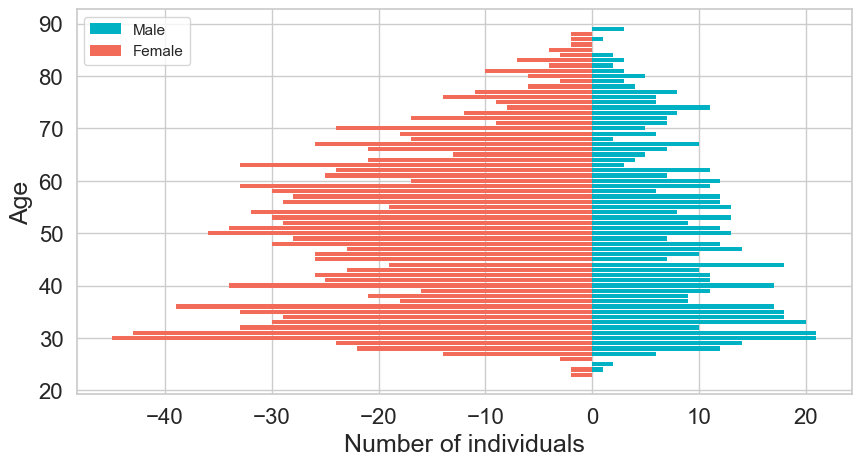

In [4]:
sns.set(style="whitegrid")
# Group the data by 'gender' and 'age' and count the number of cases for each age
age_counts = metaC.groupby(['gender', 'Age_at_MBsample']).size().unstack()
age_counts = age_counts.reset_index(drop=True).T.reset_index()

# Create a pyramid chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pyramid chart for males and females
ax.barh(age_counts.Age_at_MBsample, age_counts[0], label='Male', color='#00b1c4', linewidth=0.01)
ax.barh(age_counts.Age_at_MBsample, -age_counts[1], label='Female', color='#f26b58', linewidth=0.01)
ax.set_xlabel('Number of individuals', fontsize=18)
ax.set_ylabel('Age', fontsize=18)
#ax.set_title('Age Distribution Pyramid for Males and Females', fontsize=18)
ax.legend()
plt.tick_params(labelsize=16)
plt.savefig('results/Fig1b_Pyramid.svg', bbox_inches='tight')
plt.savefig('results/Fig1b_Pyramid.png', bbox_inches='tight')

plt.show()

Panel C. Reads number

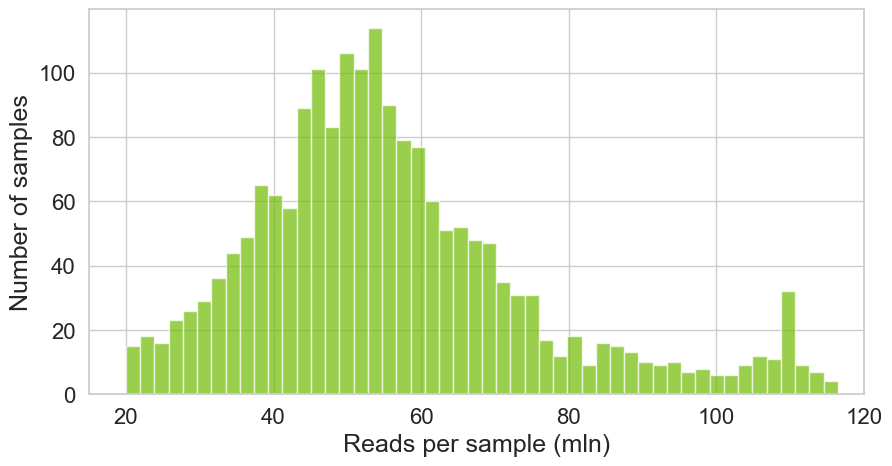

In [11]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

plt.hist(bgi['BGI_reads_numb']/1000000, bins=50, color='#70bb03', alpha=0.7)
plt.xlabel('Reads per sample (mln)', fontsize=18)
plt.ylabel('Number of samples', fontsize=18)
plt.xlim(15,120)
# label size
plt.tick_params(labelsize=16)
plt.savefig('results/Fig1c_ReadsNumb.svg', bbox_inches='tight')
plt.savefig('results/Fig1c_ReadsNumb.png', bbox_inches='tight')

Panel D. Picture with a pipeline
- Check the separate pictures
  
Panel E. Representative MAGs quality

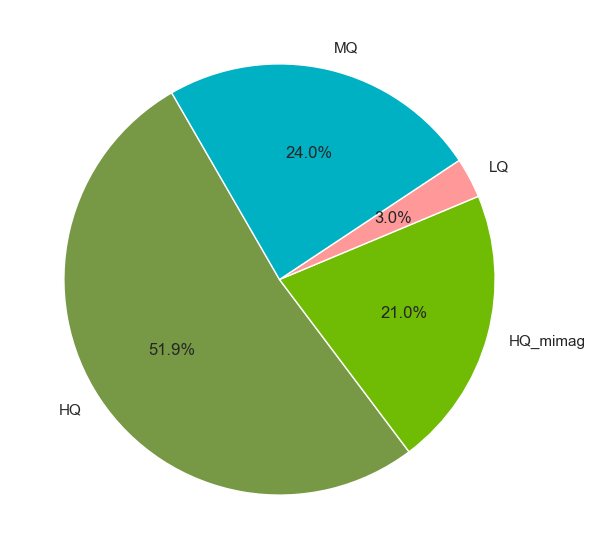

In [4]:
mq = rep['MAG_qual'].value_counts()
mq = mq.reset_index()
mq.rename(columns={'index': "mq", 'MAG_qual': "count"}, inplace=True)

mq = mq.sort_values(by='mq')

mq = rep['MAG_qual'].value_counts()
mq = mq.reset_index()
mq.rename(columns={'index': "mq", 'MAG_qual': "count"}, inplace=True)
mq = mq.sort_values(by='mq')

plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# draw a pie plot
plt.pie(mq['count'], labels=mq['mq'], autopct='%1.1f%%', startangle=120, colors=['#779945', '#70bb03', '#FF9999', '#00b1c4'])

plt.savefig('results/Fig1e_mq.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig1e_mq.svg', bbox_inches='tight')

In [5]:
mq

,mq,count
0,HQ,1172
2,HQ_mimag,475
3,LQ,68
1,MQ,542


Panel F. Representative MAGs Completeness

/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


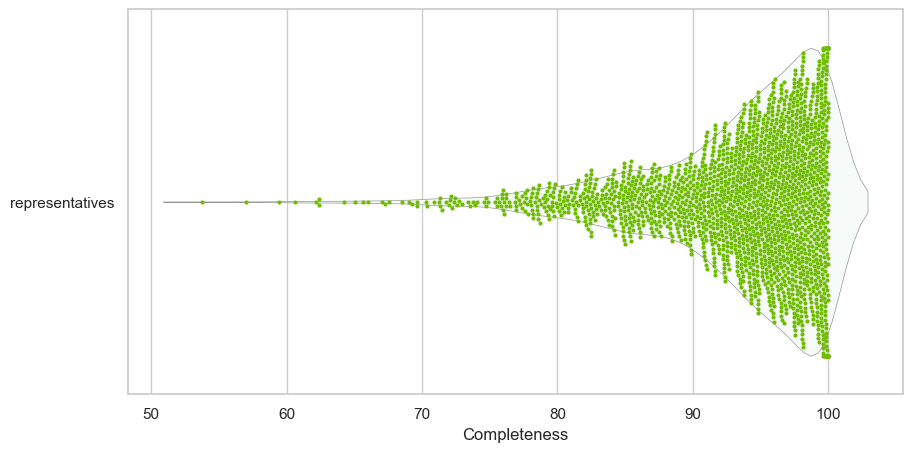

In [20]:
df = rep.copy()
df['name'] = 'representatives'

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.swarmplot(y="name", x="Completeness", data=df, size=3, color='#70bb03')
ax = sns.violinplot(y="name", x="Completeness", data=df, color='#f5fcfa',linewidth=0.5, inner=None)
plt.ylabel('')

plt.savefig('results/Fig1f_completness_cm2.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig1f_completness_cm2.svg', bbox_inches='tight')

Panel G. Representative MAGs Contamination

/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 40.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


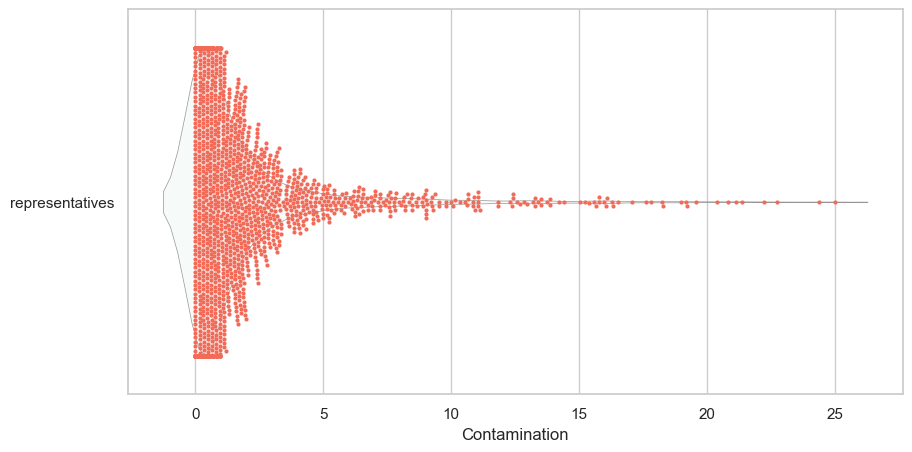

In [21]:
df['name'] = 'representatives'

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.swarmplot(y="name", x="Contamination", data=df, size=3, color='#f26b58')
ax = sns.violinplot(y="name", x="Contamination", data=df, color='#f5fcfa',linewidth=0.5, inner=None)
plt.ylabel('')

plt.savefig('results/Fig1g_contamination_cm2.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig1g_contamination_cm2.svg', bbox_inches='tight')

### Figure 2. Comparison of population specific reference with global references 
Panel A. Presence at GTDB and USGG DBs

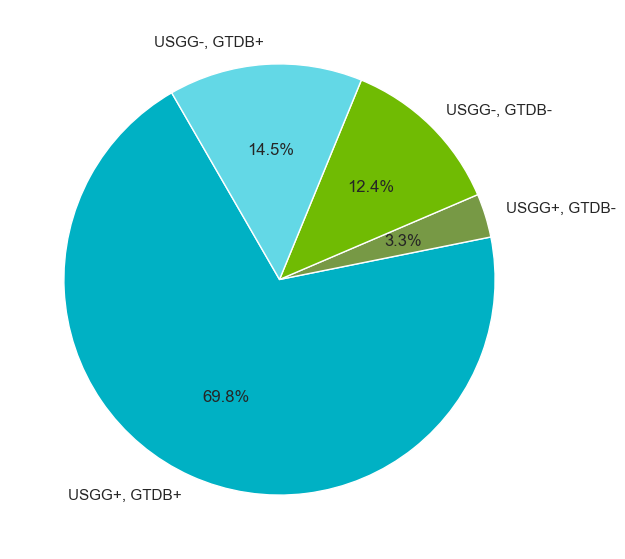

In [10]:
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")
plt.tick_params(labelsize=20)

# draw a pie plot
plt.pie([1576,74,279,328], labels=['USGG+, GTDB+','USGG+, GTDB-','USGG-, GTDB-','USGG-, GTDB+'], 
        autopct='%1.1f%%', startangle=120, colors=['#00b1c4', '#779945', '#70bb03', '#63d8e6'])


plt.savefig('results/Fig2a.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig2a.svg', bbox_inches='tight')

Panel B. Aggregated amount of a new species

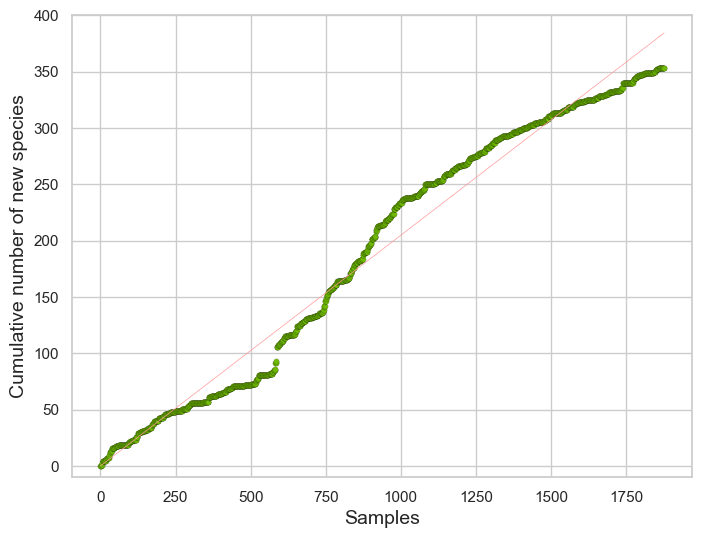

In [23]:
plt.figure(figsize=(8, 6))

plt.scatter(samples_df.index, samples_df['cumulative_undefined'], color='#70bb03', s=15, alpha=0.9, 
            label='Cumulative number of undefined species', edgecolors='black', linewidths=0.1)

plt.xlabel('Samples', fontsize=14)
plt.ylabel('Cumulative number of new species', fontsize=14)
plt.plot(X, y_pred, color=pinckC, linewidth=0.5, label='Regression line')  
plt.ylim(-10,400)
plt.grid()
plt.grid()

plt.savefig('results/2b_cumm1.png', dpi=300, bbox_inches='tight')
plt.savefig('results/2b_cumm1.svg', bbox_inches='tight')

Panel C. 

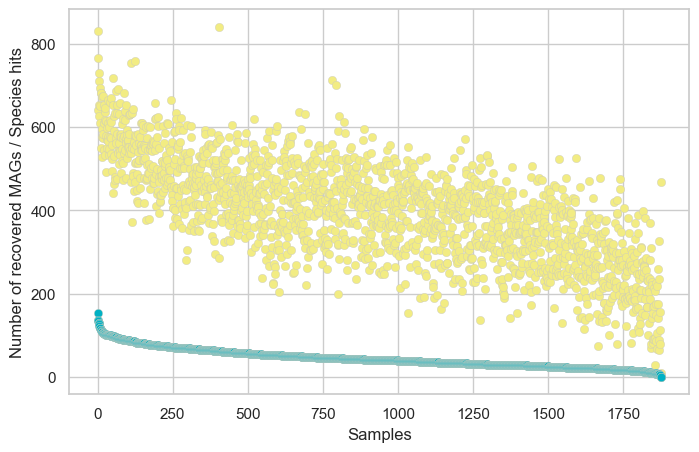

In [24]:
# rename columns
mrgN.columns = ['sample', 'MAGs number','sample_name' , 'Species hits']
# Calculate rolling mean
window_size = 100  
rolling_mean = mrgN['Species hits'].rolling(window=window_size).mean()

sns.set(style="whitegrid")
# Create a plot
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=mrgN, x=mrgN.index, y='Species hits', ax=ax, color='#f2ec83', edgecolor='#cccbbe', linewidth=0.3)
sns.scatterplot(data=mrgN, x=mrgN.index, y='MAGs number', ax=ax, color='#00b1c4', edgecolor='#cccbbe',linewidth=0.3)

plt.xlabel('Samples')
plt.ylabel('Number of recovered MAGs / Species hits')

# Plot rolling mean
#plt.plot(mrgN.index, rolling_mean, color='black', label=f'Rolling Mean ({20} window)')

plt.savefig('results/2c_mags_vs_detect.png', dpi=300, bbox_inches='tight')
plt.savefig('results/2c_mags_vs_detect.svg', bbox_inches='tight')

Panel D. Prevalence by group

In [12]:
rep

,rep_MAG_ID,cluster name,MAGs_per_cluster,genome_length,Completeness,Contamination,MAG_qual,num_seqs,domain,phylum,...,present_at_UHGG,name,perc_MAG,5S_rRNA,16S_rRNA,23S_rRNA,Total_tRNA_Types,MAGs_per_cluster_perc,prev_count,prevalence
0,H0001_Odoribacter_splanchnicus.fa,HQ-591_1,1332,4092605,99.97,0.44,HQ,26,Bacteria,Bacteroidota,...,EstMAG_overlap,Odoribacter splanchnicus,70.93%,3,0,1,21,70.926518,1810,96.379127
1,H0002_Barnesiella_intestinihominis.fa,HQ-671_1,1180,3262506,99.95,0.06,HQ_mimag,38,Bacteria,Bacteroidota,...,EstMAG_overlap,Barnesiella intestinihominis,62.83%,1,2,1,21,62.832801,1668,88.817891
2,H0003_Parabacteroides_distasonis.fa,HQ-631_1,1134,4690993,99.94,0.56,HQ,26,Bacteria,Bacteroidota,...,EstMAG_overlap,Parabacteroides distasonis,60.38%,5,0,1,22,60.383387,1730,92.119276
3,H0004_Alistipes_putredinis.fa,HQ-759_1,1024,2244385,99.99,0.36,HQ,17,Bacteria,Bacteroidota,...,EstMAG_unique,Alistipes putredinis,54.53%,0,1,0,21,54.526092,1758,93.610224
4,H0005_Agathobacter_rectalis.fa,HQ-1045_1,975,2690428,92.38,0.31,HQ,70,Bacteria,Bacillota_A,...,EstMAG_overlap,Agathobacter rectalis,51.92%,0,2,5,22,51.916933,1798,95.740149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,H2248_Ventrimonas_sp900555625.fa,HQ-978_1,1,3044173,99.05,1.96,HQ,36,Bacteria,Bacillota_A,...,EstMAG_overlap,Ventrimonas sp900555625,0.05%,0,1,6,21,0.053248,201,10.702875
2253,H2250_Gastranaerophilus_phascolarctosicola.fa,HQ-98_1,1,1720507,95.45,0.08,HQ,13,Bacteria,Cyanobacteriota,...,EstMAG_overlap,Gastranaerophilus phascolarctosicola,0.05%,0,0,0,21,0.053248,0,0.000000
2254,H2253_Limenecus_undS.fa,HQ-99_1,1,1863551,93.49,0.59,HQ,43,Bacteria,Cyanobacteriota,...,EstMAG_unique,Limenecus undS,0.05%,0,1,0,22,0.053248,2,0.106496
2255,H2255_Frisingicoccus_sp900753685.fa,HQ-995_1,1,2132722,92.35,0.03,HQ,172,Bacteria,Bacillota_A,...,EstMAG_overlap,Frisingicoccus sp900753685,0.05%,0,0,2,19,0.053248,28,1.490948


In [15]:
# prevalence by type
prevG = rep[['rep_MAG_ID', 'MAGs_per_cluster','MAGs_per_cluster_perc', 'prev_count', 'prevalence','present_at_UHGG', 'sp']].copy()  # Make a copy to avoid SettingWithCopyWarning

conditions = [
    (prevG['sp'] == 'undefined') & (prevG['present_at_UHGG'] == 'EstMAG_overlap'),
    (prevG['sp'] != 'undefined') & (prevG['present_at_UHGG'] == 'EstMAG_overlap'),
    (prevG['sp'] == 'undefined') & (prevG['present_at_UHGG'] != 'EstMAG_overlap'),
    (prevG['sp'] != 'undefined') & (prevG['present_at_UHGG'] != 'EstMAG_overlap')]

choices = [
    'GTBD-, USGG+',
    'GTBD+, USGG+',
    'GTBD-, USGG-',
    'GTBD+, USGG-']

prevG['type'] = np.select(conditions, choices, default=np.nan)
prevG = prevG.sort_values(by='type')

# custom order sort
order = ['GTBD+, USGG+', 'GTBD+, USGG-', 'GTBD-, USGG-', 'GTBD-, USGG+']
prevG['type'] = pd.Categorical(prevG['type'], categories=order, ordered=True)
prevG = prevG.sort_values('type')
prevG.to_excel('results/all_sp_prev&mags_numb.xlsx', index=False)

/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ketpantuh/Library/Python/3.8/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ketpantuh/Library/Python/

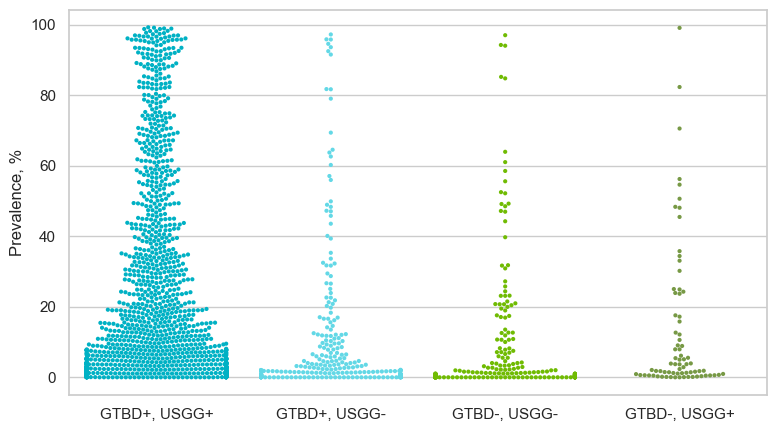

In [45]:
# colors
darckGreenC = '#779945'
greenC = '#70bb03'
darkBlueC = '#00b1c4'
blueC = '#63d8e6'

# Define colors for each type
clr = {'GTDB+, USGG+': darkBlueC,
       'GTDB+, USGG-': blueC,
       'GTDB-, USGG-': greenC,
       'GTDB-, USGG+': darckGreenC}

# Compare prevalence of overlaped and non-overlaped species
plt.figure(figsize=(9, 5))
sns.set(style="whitegrid")

ax = sns.swarmplot(x="type", y="prevalence", data=prevG, hue="type", size=3, palette=clr.values())
#ax = sns.violinplot(x="type", y="prevalence", data=prevG, color='#f5fcfa',linewidth=0.5, inner=None)
# legend false
plt.legend([],[], frameon=False)
#plt.legend(title='Type', loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel('')
plt.ylabel('Prevalence, %')

plt.savefig('results/Fig2d_prev.svg', bbox_inches='tight')
plt.savefig('results/Fig2d_prev.png', bbox_inches='tight')

Panel E. Top 10 new sp. Number of recovered genomes and Prevalence by mapping

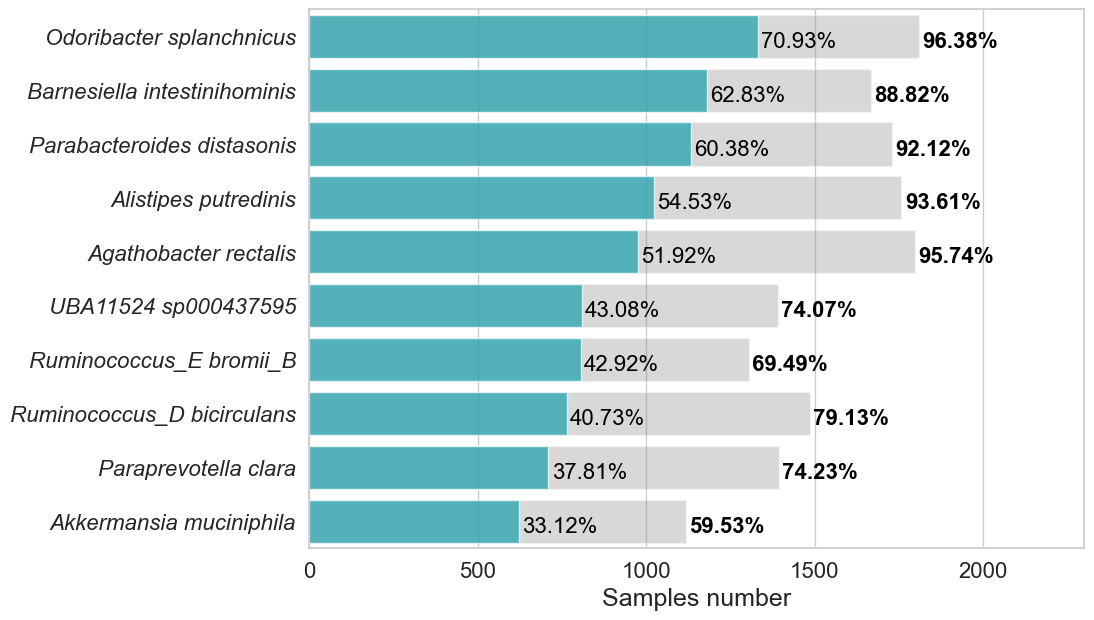

In [11]:
# plot common bins
pic1 = rep.sort_values(by='MAGs_per_cluster', ascending=False).head(10)
pic1 = pic1[['rep_MAG_ID', 'MAGs_per_cluster', 'MAGs_per_cluster_perc','prev_count', 'prevalence', 'present_at_UHGG', 'sp']]
pic1['MAGs_per_cluster_perc'] = pic1['MAGs_per_cluster_perc'].round(2)
pic1['prevalence'] = pic1['prevalence'].round(2)
pic1.to_excel('results/top10_common_bins.xlsx', index=False)

plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.barplot(x="prev_count", y="sp", data=pic1, color='grey', alpha=0.3)
sns.barplot(x="MAGs_per_cluster", y="sp", data=pic1, color='#04b4c4', alpha=0.7)
plt.xlim(0, 2300)
# make y labes italic
plt.yticks(fontstyle='italic')

plt.xlabel('Samples number', fontsize=18)
plt.ylabel('', fontsize=18)
plt.tick_params(labelsize=16)

# add annotation one by one with a loop
for line in range(0,pic1.shape[0]):
     plt.text(pic1['prev_count'][line]+10, line+0.2, str(pic1['prevalence'][line]) + '%',
             horizontalalignment='left', color='black', fontsize=16, weight='semibold')
     
# add annotation one by one with a loop
for line in range(0,pic1.shape[0]):
     plt.text(pic1['MAGs_per_cluster'][line]+10, line+0.2, str(pic1['MAGs_per_cluster_perc'][line]) + '%',
             horizontalalignment='left', color='black', fontsize=16)
     
plt.savefig('results/Fig2e_bin_per_cluster_comm.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig2e_bin_per_cluster_comm.svg', bbox_inches='tight')

Panel F. Top 15 non overlap sp. Number of recovered genomes and Prevalence by mapping

In [10]:
pic3 = rep[rep['sp'] == 'undefined'].sort_values(by='MAGs_per_cluster', ascending=False).head(10)
pic3 = pic3[['rep_MAG_ID', 'MAGs_per_cluster', 'MAGs_per_cluster_perc','prev_count', 'prevalence', 'present_at_UHGG', 'sp']]
pic3['MAGs_per_cluster_perc'] = pic3['MAGs_per_cluster_perc'].round(2)
pic3['prevalence'] = pic3['prevalence'].round(2)

pic3['genus'] = pic3['rep_MAG_ID'].str.split('_').str[1]
pic3['name'] = 'undefined sp from genus '+pic3['genus']
pic3.to_excel('results/undefined_sp.xlsx', index=False)

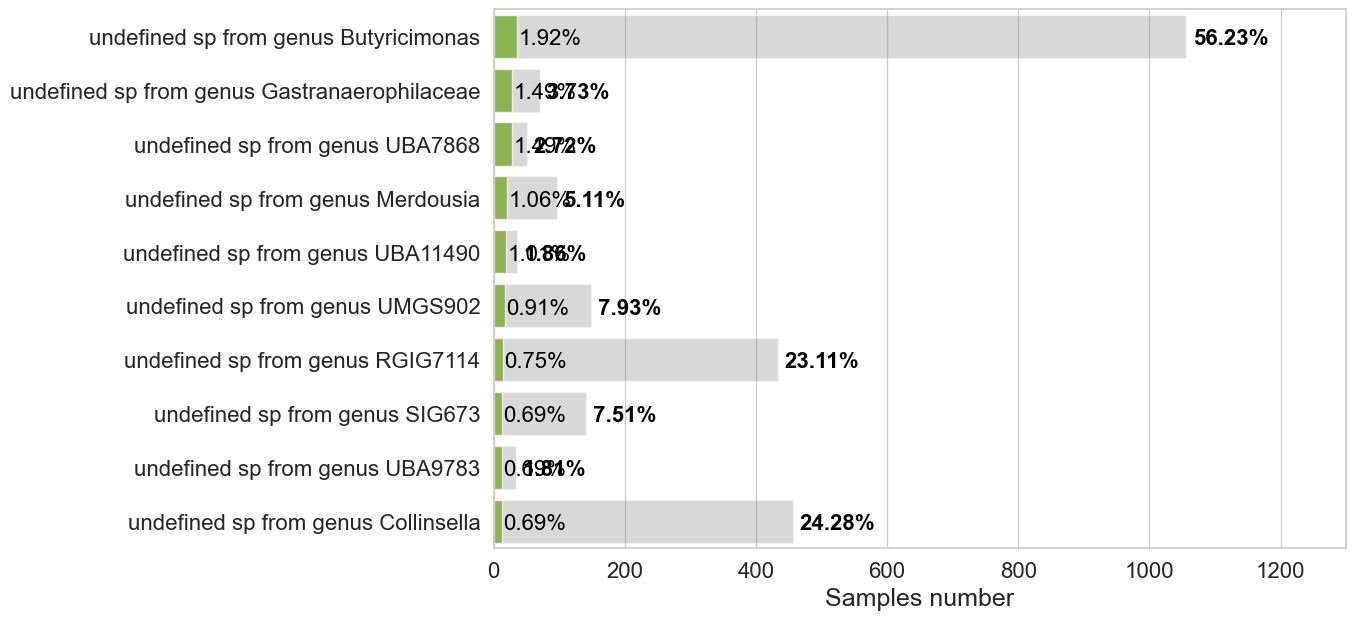

In [75]:
# plot EstUnique bins
pic3 = rep[rep['sp'] == 'undefined'].sort_values(by='MAGs_per_cluster', ascending=False).head(10)
pic3 = pic3[['rep_MAG_ID', 'MAGs_per_cluster', 'MAGs_per_cluster_perc','prev_count', 'prevalence', 'present_at_UHGG', 'sp']]
pic3 = pic3.reset_index()
pic3['MAGs_per_cluster_perc'] = pic3['MAGs_per_cluster_perc'].round(2)
pic3['prevalence'] = pic3['prevalence'].round(2)
pic3['genus'] = pic3['rep_MAG_ID'].str.split('_').str[1]
pic3['name'] = 'undefined sp from genus '+pic3['genus']

plt.figure(figsize=(11, 7))
sns.set(style="whitegrid")

sns.barplot(x="prev_count", y="name", data=pic3, color='grey', alpha=0.3)
sns.barplot(x="MAGs_per_cluster", y="name", data=pic3, color='#70bb03', alpha=0.7)
plt.xlim(0, 1300)
# make y labes italic
#plt.yticks(fontstyle='italic')

plt.xlabel('Samples number', fontsize=18)
plt.ylabel('', fontsize=18)
plt.tick_params(labelsize=16)

# add annotation one by one with a loop
for line in range(0,pic3.shape[0]):
     plt.text(pic3['MAGs_per_cluster'][line]+2, line+0.15, str(pic3['MAGs_per_cluster_perc'][line]) + '%', 
             horizontalalignment='left', color='black', fontsize=16)
     
# add annotation one by one with a loop
for line in range(0,pic3.shape[0]):
     plt.text(pic3['prev_count'][line]+10, line+0.15, str(pic3['prevalence'][line]) + '%', 
             horizontalalignment='left', color='black', weight='semibold', fontsize=16)
     
plt.savefig('results/Fig2f_prev_NewSp.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Fig2f_prev_NewSP.svg', bbox_inches='tight')

### Figure 3. Metagenome-wide association between the abundance of gut bacterial species and disease.
Check at the separate script "EstMB_MWAS.ipyb"

# Supplementary

### Figure S1. Phylum of all representative MAGs.

In [15]:
sns.color_palette("Set3")

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [23]:
print(sns.color_palette("Set3").as_hex())

['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']


In [10]:
phy1['color'] = phy1['phylum'].map({'Bacillota_A': '#8dd3c7', 'Bacteroidota': '#ffed6f', 
                                  'Bacillota': '#80b1d3', 'Bacillota_C': '#b3de69', 
                                  'other': '#d9d9d9', 'Verrucomicrobiota': '#fb8072', 
                                  'Pseudomonadota': '#bebada', 'Cyanobacteriota': '#fccde5',
                                  'Actinomycetota': '#bebada'})
phy

,phylum,count
0,Bacillota_A,1213
1,Bacteroidota,337
2,Bacillota,212
3,Pseudomonadota,159
4,Cyanobacteriota,78
5,Actinomycetota,70
6,Verrucomicrobiota,58
7,Bacillota_C,45
8,Desulfobacterota,29
9,Campylobacterota,12


/var/folders/fr/j_4kmkcj6zs6nglntg64jfgr0000gn/T/ipykernel_47840/1280427735.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phy1 = phy1.append(new_data, ignore_index=True)


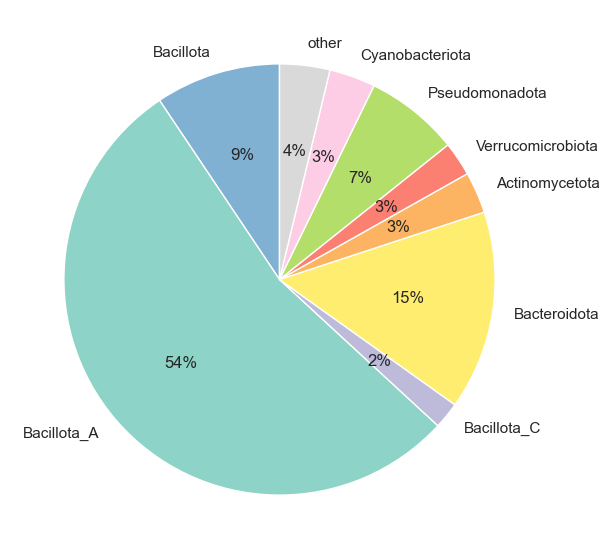

In [19]:
phy = rep['phylum'].value_counts()
phy = phy.reset_index()
phy.rename(columns={'index': "phylum", 'phylum': "count"}, inplace=True)
phy1 = phy.head(8)
phy1 = phy1.sort_values(by='phylum', ascending=False)
other = phy[8:]['count'].sum()
new_data = pd.Series(['other', other], index=phy1.columns)
phy1 = phy1.append(new_data, ignore_index=True)

phy1['color'] = phy1['phylum'].map({'Bacillota_A': '#8dd3c7', 'Bacteroidota': '#ffed6f', 
                                  'Bacillota': '#80b1d3', 'Bacillota_C': '#bebada', 
                                  'other': '#d9d9d9', 'Verrucomicrobiota': '#fb8072', 
                                  'Pseudomonadota': '#b3de69', 'Cyanobacteriota': '#fccde5',
                                  'Actinomycetota': '#fdb462'})

# custom raw order for phy1
phy1 = phy1.reindex([6, 5, 4, 3, 7, 0, 1, 2, 8])

plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")
colors = sns.color_palette("Set3")

# draw a pie plot
plt.pie(phy1['count'], labels=phy1['phylum'], autopct='%1.0f%%', startangle=90, colors=phy1['color'])

plt.savefig('results/S1_phylum.png', dpi=300, bbox_inches='tight')
plt.savefig('results/S1_phylum.svg', bbox_inches='tight')

In [35]:
print(1576+74)
print(328+279)

print(1576+74+328+279)
print(279+74)

1650
607
2257
353


In [30]:
phy1 = phy1.sort_values(by='count', ascending=False)
print('Number of top-3 phyla MAGs', str(phy1[0:3]['count'].sum()), '(', str(phy1[0:3]['count'].sum()/len(rep)*100)[0:5], '%)')
print('Number of Bacillota_A phyla MAGs', str(phy1[0:1]['count'].sum()), '(', str(phy1[0:1]['count'].sum()/len(rep)*100)[0:5], '%)')
print('Number of Bacteroidota phyla MAGs', str(phy1[1:2]['count'].sum()), '(', str(phy1[1:2]['count'].sum()/len(rep)*100)[0:5], '%)')
print('Number of Bacillota phyla MAGs', str(phy1[2:3]['count'].sum()), '(', str(phy1[2:3]['count'].sum()/len(rep)*100)[0:5], '%)')

Number of top-3 phyla MAGs 1762 ( 78.06 %)
Number of Bacillota_A phyla MAGs 1213 ( 53.74 %)
Number of Bacteroidota phyla MAGs 337 ( 14.93 %)
Number of Bacillota phyla MAGs 212 ( 9.392 %)


### Figure S2. Bacterial species with the higher number of MAGs per species cluster.

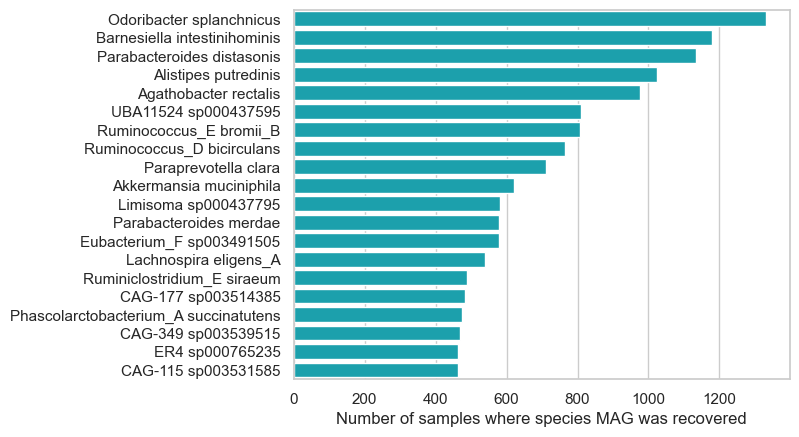

In [76]:
tp_sp = rep[['sp','MAGs_per_cluster']].head(20)
tp_sp = tp_sp.set_index('sp')
sns.barplot(y=tp_sp.index, x='MAGs_per_cluster', data=tp_sp, color='#04b4c4')
plt.ylabel('')
plt.xlabel('Number of samples where species MAG was recovered')

plt.savefig('results/S2_top_sp.png', dpi=300, bbox_inches='tight')
plt.savefig('results/S2_top_sp.svg', bbox_inches='tight')

### Figure S3. Number of recovered genomes per cluster for a new species.

<Figure size 1000x500 with 0 Axes>

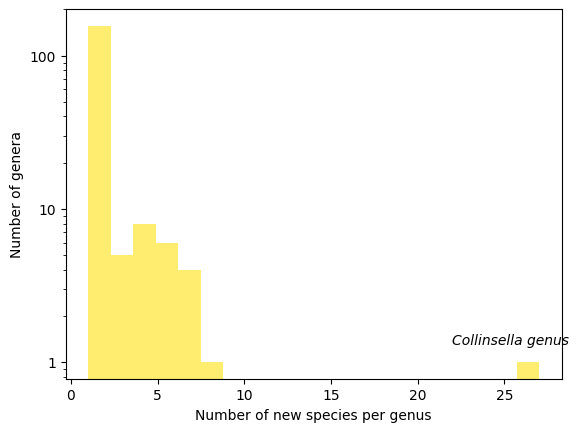

In [50]:
new = rep[rep['sp'] == 'undefined']
s3 = new['genus'].value_counts()
s3 = s3.reset_index()
s3.rename(columns={'index': "genus", 'genus': "count"}, inplace=True)
# skip raw if genus == 'undefined'
s3 = s3[s3['genus'] != 'undefined']

plt.figure(figsize=(10, 5))
s3.hist(bins=20, color='#ffed6f', alpha=1)
plt.xlabel('Number of new species per genus')
plt.ylabel('Number of genera')
plt.title('')
# log scale
plt.yscale('log')
plt.yticks(ticks=[1, 10, 100], labels=['1', '10', '100'])
plt.grid(False)

plt.text(22, 1.3, 'Collinsella genus', fontstyle='italic')
plt.savefig('results/S3.png', dpi=300, bbox_inches='tight')
#plt.savefig('results/S3.svg', bbox_inches='tight')

### Figure S4. Number of recovered genomes per species. 

In [39]:
# mofidy abud table for calculation
abudT = abud.T
new_header = abudT.iloc[0]
abudT = abudT[1:]
abudT.columns = new_header

# Select only new species
abudTn = abudT[abudT.index.str.contains('und')]
abudTn = abudTn.T
abudTn.head(2)

,H2010_Oxalobacter_undS,H1469_Alistipes_A_undS,H1671_Borkfalkia_undS,H1635_Dysosmobacter_undS,H2124_Hafnia_undS,H1642_UBA4068_undG,H1839_UBA1206_undS,H2128_Alistipes_undS,H1669_CAG-508_undG,H1198_RUG666_undS,...,H1078_Citrobacter_freundii,H2169_Prevotella_undS,H2023_Collinsella_undS,H1759_Caccovivens_undS,H0710_CAKVNM01_undS,H1833_QANA01_undS,H1720_SIG440_undS,H2254_Frisingicoccus_undS,H0998_CAG-448_undS,H1699_Scatenecus_undS
index,,,,,,,,,,,,,,,,,,,,,
VB48BW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016168,0.0,0.0,0.0,0.0
VOK6OK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.881941,0.0,0.0,0.0,0.005033,0.0,0.0,0.0,0.0


In [38]:
# calculate the sum value for each raw
abudTn_sum = abudTn.copy()
abudTn_sum['new_sp_sum_abud'] = abudTn.sum(axis=1)
abudTn_sum = abudTn_sum['new_sp_sum_abud'].to_frame()
abudTn_sum.sort_values(by='new_sp_sum_abud', ascending=False, inplace=True)

# calculate the sum value for each raw
abudTn_numb = abudTn.copy()
abudTn_numb['new_sp_numb'] = abudTn.astype(bool).sum(axis=1)
abudTn_numb = abudTn_numb['new_sp_numb'].to_frame()
abudTn_numb.sort_values(by='new_sp_numb', ascending=False, inplace=True)

# calculate number of all detected species for each sample
abud['sp_numb'] = abud.astype(bool).sum(axis=1)
abud1 = abud[['index', 'sp_numb']]
# merge new sp counts with all sp counts
mrg = abudTn_numb.merge(abud1, on='index', how='inner')

# mrg2
mrg2 = mrg.merge(abudTn_sum, on='index', how='inner')
mrg2['non_new_sp_sum_abud'] = 100 - mrg2['new_sp_sum_abud']

mrg2.to_excel('results/S4_data.xlsx')
mrg2.head(2)

,index,new_sp_numb,sp_numb,new_sp_sum_abud,non_new_sp_sum_abud
0,VY8V5H,88,769,2.396598,97.603402
1,VM14J6,87,834,3.740583,96.259417


In [58]:
mrg2.sort_values(by='new_sp_sum_abud', ascending=False).head(2)

,index,new_sp_numb,sp_numb,new_sp_sum_abud,non_new_sp_sum_abud
1787,VQWUQN,9,201,34.756597,65.243403
1868,VLZ378,4,117,14.787097,85.212903


In [44]:
print('Average number of detected new species:', mrg2['new_sp_numb'].mean())
print('Total relative abundance of a new species:', mrg2['new_sp_sum_abud'].mean())
print('---')
print('Min number of detected new species:', mrg2['new_sp_numb'].min())
print('Max number of detected new species:', mrg2['new_sp_numb'].max())
print('---')
print('Min relative abundance of a new species:', mrg2['new_sp_sum_abud'].min())
print('Max relative abundance of a new species:', mrg2['new_sp_sum_abud'].max())

Average number of detected new species: 30.307774227902023
Total relative abundance of a new species: 3.9874194761323754
---
Min number of detected new species: 1
Max number of detected new species: 88
---
Min relative abundance of a new species: 0.5424703453
Max relative abundance of a new species: 34.7565969967


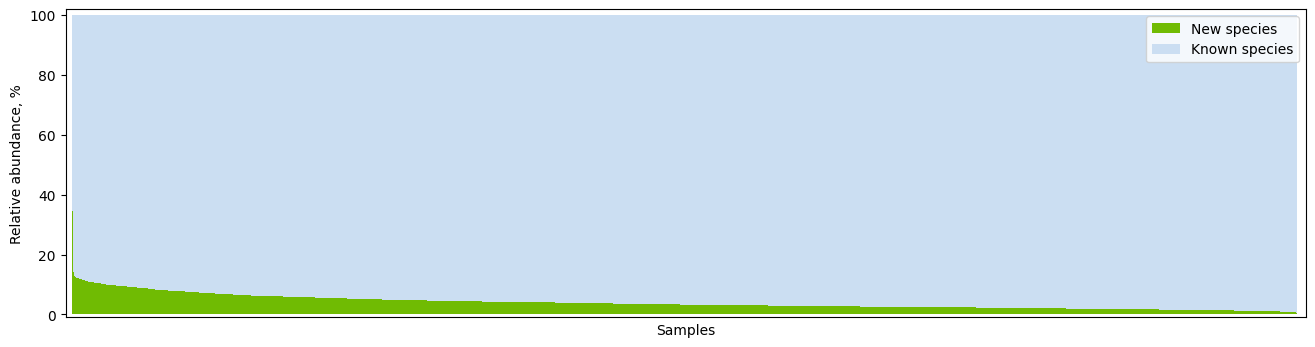

In [57]:
picS4_data = mrg2[['new_sp_sum_abud','non_new_sp_sum_abud']].sort_values(by='new_sp_sum_abud', ascending=False)
picS4_data.plot(kind='bar', stacked=True, color=['#70bb03','#cbdef2'], width=1,figsize=(16, 4))
plt.xlabel('Samples')
plt.ylabel('Relative abundance, %')
plt.xlim(-10, 1890)
plt.ylim(-1, 102)
plt.xticks([])
# rename legend
plt.legend(['New species', 'Known species'], loc='best')

plt.savefig('results/S4.png', dpi=300, bbox_inches='tight')
plt.savefig('results/S4.svg', bbox_inches='tight')

### Figure S5. Relationship between Species Prevalence and number of samples where species genome was assembled.

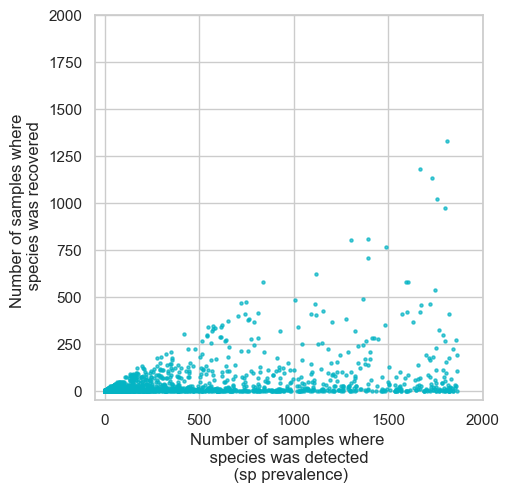

In [21]:
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
repS6 = rep[['sp','MAGs_per_cluster','prev_count']].copy()

plt.scatter(repS6['prev_count'],repS6['MAGs_per_cluster'], s=5, color='#04b4c4', alpha=0.7)
plt.xlabel('Number of samples where \n species was detected \n (sp prevalence)')
plt.ylabel('Number of samples where \n species was recovered')
plt.xlim(-50, 2000)
plt.ylim(-50, 2000)
plt.xticks(np.arange(0, 2001, 500))
#plt.yticks(np.arange(0, 2001, 500))

plt.savefig('results/S6.png', dpi=300, bbox_inches='tight')
plt.savefig('results/S6.svg', bbox_inches='tight')